In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", category=DeprecationWarning) 
warnings.simplefilter("ignore", category=UserWarning)

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

njobs = -1

In [2]:
train=pd.read_csv('../1. Task and Data/train.csv',sep='|')
test=pd.read_csv('../1. Task and Data/test.csv',sep='|')

In [6]:
print(train.fraud.value_counts())
print(train.fraud.value_counts() / len(train))

0    1775
1     104
Name: fraud, dtype: int64
0    0.944651
1    0.055349
Name: fraud, dtype: float64


# Feature Engineering

derived directly from given features

In [7]:
train['scannedLineItems'] = train['scannedLineItemsPerSecond'] * train['totalScanTimeInSeconds']
train['pricePerScannedLineItem'] = train['grandTotal'] / train['scannedLineItems']
train['scansWithoutRegistrationPerScannedLineItem'] = train['scansWithoutRegistration'] / train['scannedLineItems']
train['quantityModificationsPerScannedLineItem'] = train['quantityModifications'] / train['scannedLineItems']
train['lineItemVoidsPerSecond'] = train['lineItemVoids'] / train['totalScanTimeInSeconds']
train['scansWithoutRegistrationPerSecond'] = train['scansWithoutRegistration'] / train['totalScanTimeInSeconds']
train['quantityModificationsPerSecond'] = train['quantityModifications'] / train['totalScanTimeInSeconds']
train['secondsPerEuro'] = train['totalScanTimeInSeconds'] / train['grandTotal']
train['lineItemVoidsPerEuro'] = train['lineItemVoids'] / train['grandTotal']
train['scansWithoutRegistrationPerEuro'] = train['scansWithoutRegistration'] / train['grandTotal']
train['quantityModificationsPerEuro'] = train['quantityModifications'] / train['grandTotal']

test['scannedLineItems'] = test['scannedLineItemsPerSecond'] * test['totalScanTimeInSeconds']
test['pricePerScannedLineItem'] = test['grandTotal'] / test['scannedLineItems']
test['scansWithoutRegistrationPerScannedLineItem'] = test['scansWithoutRegistration'] / test['scannedLineItems']
test['quantityModificationsPerScannedLineItem'] = test['quantityModifications'] / test['scannedLineItems']
test['lineItemVoidsPerSecond'] = test['lineItemVoids'] / test['totalScanTimeInSeconds']
test['scansWithoutRegistrationPerSecond'] = test['scansWithoutRegistration'] / test['totalScanTimeInSeconds']
test['quantityModificationsPerSecond'] = test['quantityModifications'] / test['totalScanTimeInSeconds']
test['secondsPerEuro'] = test['totalScanTimeInSeconds'] / test['grandTotal']
test['lineItemVoidsPerEuro'] = test['lineItemVoids'] / test['grandTotal']
test['scansWithoutRegistrationPerEuro'] = test['scansWithoutRegistration'] / test['grandTotal']
test['quantityModificationsPerEuro'] = test['quantityModifications'] / test['grandTotal']

In [8]:
test.loc[test['grandTotal'] == 0.00, 'secondsPerEuro'] = test['totalScanTimeInSeconds'] / 0.01
test.loc[test['grandTotal'] == 0.00, 'lineItemVoidsPerEuro'] = test['lineItemVoids'] / 0.01
test.loc[test['grandTotal'] == 0.00, 'scansWithoutRegistrationPerEuro'] = test['scansWithoutRegistration'] / 0.01
test.loc[test['grandTotal'] == 0.00, 'quantityModificationsPerEuro'] = test['quantityModifications'] / 0.01

# Defining different oversampling strategies
- Classical Oversampling
- SMOTE Technique
- ADASYN Technique

Each one has a slightly different approach for generating synthetic instances
- Simply duplicated fraud instances
- ADASYN focuses on generating samples next to the original samples which are wrongly classified using a k-Nearest Neighbors classifier
- SMOTE will not make any distinction between easy and hard samples to be classified using the nearest neighbors rule.


In [9]:
# !pip install imblearn  # might be necessary for installation
from imblearn.over_sampling import RandomOverSampler

def randomOverSampling(train):
    ros = RandomOverSampler(random_state=42, ratio = 1)
    X_train_extended, Y_train_extended = ros.fit_resample(train.drop('fraud',axis=1), train['fraud'])

    new_train = pd.DataFrame(X_train_extended, columns=train.drop('fraud',axis=1).columns) 
    new_train["fraud"] = Y_train_extended
    return new_train

print(randomOverSampling(train).fraud.value_counts())
print(randomOverSampling(train).fraud.value_counts() / len(randomOverSampling(train)))

1    1775
0    1775
Name: fraud, dtype: int64
1    0.5
0    0.5
Name: fraud, dtype: float64


In [10]:
#!pip install imblearn
from imblearn.over_sampling import SMOTE

def smoteOverSamling(train):
    sm = SMOTE(random_state=42, k_neighbors = 3, ratio = 1)
    X_train_extended, Y_train_extended = sm.fit_sample(train.drop('fraud',axis=1), train['fraud'])

    new_train = pd.DataFrame(X_train_extended, columns=train.drop('fraud',axis=1).columns) 
    new_train ["fraud"] = Y_train_extended
    return new_train
    
print(smoteOverSamling(train).fraud.value_counts())
print(smoteOverSamling(train).fraud.value_counts() / len(smoteOverSamling(train)))

1    1775
0    1775
Name: fraud, dtype: int64
1    0.5
0    0.5
Name: fraud, dtype: float64


In [11]:
from imblearn.over_sampling import ADASYN

def adasynOverSamling(train):
    ada = ADASYN(random_state=42, n_neighbors = 3, ratio = 1)
    X_train_extended, Y_train_extended = ada.fit_resample(train.drop('fraud',axis=1), train['fraud'])

    new_train = pd.DataFrame(X_train_extended, columns=train.drop('fraud',axis=1).columns) 
    new_train["fraud"] = Y_train_extended
    return new_train
    
print(adasynOverSamling(train).fraud.value_counts())
print(adasynOverSamling(train).fraud.value_counts() / len(adasynOverSamling(train)))

0    1775
1    1747
Name: fraud, dtype: int64
0    0.503975
1    0.496025
Name: fraud, dtype: float64


# Defining the Custom Score Function based on the given cost matrix

In [12]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import make_scorer

def my_custom_loss_func(y_true, y_pred):
    cm = confusion_matrix(y_true,y_pred)
    tn, fp, fn, tp = cm.ravel()
    score = ((-25)*fp + (-5)*fn + 5*tp) / len(y_true)
    return (score)

my_custom_score = make_scorer(my_custom_loss_func, greater_is_better=True)

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import LeaveOneOut

skf = StratifiedKFold(n_splits=10)
loo = LeaveOneOut()

# Building the model factory

In [25]:
from sklearn.tree import ExtraTreeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors.classification import KNeighborsClassifier
from sklearn.ensemble.weight_boosting import AdaBoostClassifier
from sklearn.ensemble.gradient_boosting import GradientBoostingClassifier
from sklearn.ensemble.bagging import BaggingClassifier
from sklearn.ensemble.forest import ExtraTreesClassifier
from sklearn.ensemble.forest import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestCentroid
from sklearn.linear_model import Perceptron
from sklearn.neural_network.multilayer_perceptron import MLPClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.svm import SVC
from xgboost import XGBClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV



model_tuning_factory = [   
    GridSearchCV(LogisticRegression(max_iter = 10000), 
                 dict(solver = ['newton-cg', 'lbfgs', 'liblinear'], 
                      fit_intercept = [True, False],
                      C = np.arange(0.1, 2.0, 0.1)),
                 cv = skf,
                 scoring = my_custom_score,
                 refit = True,
                 n_jobs = -1),
    GridSearchCV(KNeighborsClassifier(), 
                 dict(
                     n_neighbors = [1, 3, 5, 10, 15],
                     weights = ['uniform', 'distance'],
                     p = [1, 2, 3]
                 ),
                 cv = skf,
                 scoring = my_custom_score,
                 refit = True,
                 n_jobs = -1),
  #  GridSearchCV(NearestCentroid(),    # cause some problems
  #               dict(metric = ['euclidean', 'manhattan', 'chebyshev', 'minkowski', 'mahalanobis']),
  #               cv = skf,
  #               scoring = my_custom_score,
  #               refit = True,
  #               n_jobs = -1),
    GridSearchCV(DecisionTreeClassifier(),
                 dict(criterion = ['entropy', 'gini'],
                      splitter = ['best', 'random'],
                      max_depth = range(1,50,2),
                      min_samples_split = range(2,10,2)),
                 cv = skf,
                 scoring = my_custom_score,
                 refit = True,
                 n_jobs = -1),
    GridSearchCV(ExtraTreeClassifier(),
                 dict(criterion = ['entropy', 'gini'],
                      splitter = ['best', 'random'],
                      max_depth = range(1,50,2),
                      min_samples_split = range(2,10,2)),
                 cv = skf,
                 scoring = my_custom_score,
                 refit = True,
                 n_jobs = -1),
    GridSearchCV(ExtraTreesClassifier(),
                 dict(n_estimators = range(5,200,5),
                      criterion = ['entropy', 'gini']),
                 cv = skf,
                 scoring = my_custom_score,
                 refit = True,
                 n_jobs = -1),    
    GridSearchCV(RandomForestClassifier(),
                 dict(n_estimators = range(5,200,5),
                      criterion = ['entropy', 'gini']),
                 cv = skf,
                 scoring = my_custom_score,
                 refit = True,
                 n_jobs = -1),    
    GridSearchCV(BernoulliNB(),
                 dict(binarize  = [0.0, 0.2, 0.5, 1, 2],
                      alpha = [0, 0.2, 0.5, 1, 2]),
                 cv = skf,
                 scoring = my_custom_score,
                 refit = True,
                 n_jobs = -1),     
    GridSearchCV(GaussianNB(),
                 dict(),
                 cv = skf,
                 scoring = my_custom_score,
                 refit = True,
                 n_jobs = -1),     
    GridSearchCV(GradientBoostingClassifier(),
                 dict(loss = ['deviance', 'exponential'],
                      n_estimators = [20, 50,100, 150, 200]),
                 #dict(n_estimators = range(1,150)),
                 #     learning_rate = np.arange(0.01, 1.0, 0.01)),
                 cv = skf,
                 scoring = my_custom_score,
                 refit = True,
                 n_jobs = -1),
    GridSearchCV(AdaBoostClassifier(),
                 dict(n_estimators = [20, 50,100, 150, 200],
                      algorithm = ['SAMME', 'SAMME.R'],
                      base_estimator = [DecisionTreeClassifier(max_depth=1), # default setting
                                        LogisticRegression(),
                                        ExtraTreesClassifier(),
                              #          GradientBoostingClassifier(), # takes a long time (-> + 30 sec)
                              #          RandomForestClassifier(),  # takes a long time (-> + 30 sec)
                                        DecisionTreeClassifier(),
                                        ExtraTreeClassifier(),
                                        None] # default
                      ),
                 cv = skf,
                 scoring = my_custom_score,
                 refit = True,
                 n_jobs = -1), 
    GridSearchCV(XGBClassifier(),
                 dict(objective = ['binary:logistic'],
                      eval_metric = ['error'],
                      base_score = [0.3, 0.5, 0.7],
                      learning_rate = [0.01, 0.1, 0.2, 0.3],
                      n_estimators = [10, 20, 50, 100]),
                 cv = skf,
                 scoring = my_custom_score,
                 refit = True,
                 n_jobs = -1),
    GridSearchCV(XGBClassifier(),
                 dict(objective = ['binary:logistic'],
                      eval_metric = ['error'],
                   #   base_score = [0.3, 0.5, 0.7],
                   #   learning_rate = [0.01, 0.1, 0.2, 0.3],
                      n_estimators = [10, 20, 50, 100],
                      base_estimator = [DecisionTreeClassifier(max_depth=1), # default setting for AdaBoost
                                        LogisticRegression(),
                                        ExtraTreesClassifier(),
                              #          GradientBoostingClassifier(), # takes a long time (-> + 30 sec)
                              #          RandomForestClassifier(),  # takes a long time (-> + 30 sec)
                                        DecisionTreeClassifier(),
                                        ExtraTreeClassifier(),
                                        None]),
                 cv = skf,
                 scoring = my_custom_score,
                 refit = True,
                 n_jobs = -1),
    GridSearchCV(BaggingClassifier(), 
                 dict(n_estimators = [5, 10, 20, 50, 100, 150, 200],
                      base_estimator = [DecisionTreeClassifier(max_depth=1), # default setting for AdaBoost
                                        LogisticRegression(),
                                        ExtraTreesClassifier(),
                              #          GradientBoostingClassifier(), # takes a long time (-> + 30 sec)
                              #          RandomForestClassifier(),  # takes a long time (-> + 30 sec)
                                        DecisionTreeClassifier(),
                                        ExtraTreeClassifier(),
                                        None]),   # standard -> 'Decision Tree'
                 cv = skf,
                 scoring = my_custom_score,
                 refit = True,
                 n_jobs = -1), 
    GridSearchCV(Perceptron(),
                 dict(penalty = ['l2', 'l1', 'elasticnet', None],
                      alpha = np.arange(0.0005, 0.001, 0.0005),
                      fit_intercept = [True, False],
                      max_iter = range(5,100,5)),
                 cv = skf,
                 scoring = my_custom_score,
                 refit = True,
                 n_jobs = -1), 
    GridSearchCV(MLPClassifier(),
                 dict(solver = ['lbfgs', 'sgd', 'adam'],
                      activation = ['identity', 'logistic', 'tanh', 'relu'],
                      learning_rate = ['constant', 'invscaling', 'adaptive']),
                 cv = skf,
                 scoring = my_custom_score,
                 refit = True,
                 n_jobs = -1), 
#    GridSearchCV(LinearDiscriminantAnalysis(),                       # tsne dimensions cause problems
#                 dict(solver  = ['svd', 'lsqr', 'eigen'],
#                      n_components = range(1,20)),
#                 cv = skf,
#                 scoring = my_custom_score,
#                 refit = True,
#                 n_jobs = -1),
    GridSearchCV(QuadraticDiscriminantAnalysis(),
                 dict(reg_param = np.arange(0.1, 1.0, 0.1)),
                 cv = skf,
                 scoring = my_custom_score,
                 refit = True,
                 n_jobs = -1),
    GridSearchCV(SVC(),                                           # gets very slow at some point
                 dict(C = [0.01, 0.1, 0.5, 1, 2]),
                  cv = skf,
                  scoring = my_custom_score,
                  refit = True,
                  n_jobs = -1)
]       


model_tuning_factory_temp = [

]

In [27]:
import time
import random
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif

from sklearn.feature_selection import RFECV
from sklearn.feature_selection import RFE

from sklearn.preprocessing import MinMaxScaler 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer

from math import log

result_table = pd.DataFrame(columns=["Model", "Oversampling Strategy", "Data Preparation", "Feature Count", "Feature Selection Technique", "Features", "Optimal Parameters", "Monetary Value Per Instance - Mean", "Monetary Value Per Instance - Standard Deviation", "Raw Model", 'Cross Validation Results'])

for oversampling_strategy in range(1,2):  # Oversamling strategies not in the loop
    if (oversampling_strategy == 1):  
        Y = train['fraud']
        X = train.drop('fraud',axis=1)
        oversampling = "No Oversampling"
    elif (oversampling_strategy == 2):
        extended_train = randomOverSampling(train)
        Y = extended_train['fraud']
        X = extended_train.drop('fraud',axis=1)
        oversampling = "Random Oversampling"
    elif (oversampling_strategy == 3):
        extended_train = smoteOverSamling(train)
        Y = extended_train['fraud']
        X = extended_train.drop('fraud',axis=1)
        oversampling = "SMOTE"
    elif (oversampling_strategy == 3):
        extended_train = adasynOverSamling(train)
        Y = extended_train['fraud']
        X = extended_train.drop('fraud',axis=1)
        oversampling = "Adaysin"
            
    # four types of data preparation: No preparation, MaxMinScaler, StandardScaler, LogScaling
    for data_preparation_strategy in range(1,5):
        if (data_preparation_strategy == 1):  
            X_scaled = X
            data_preparation = "No Scaling"
        elif (data_preparation_strategy == 2):
            feature_scaler = MinMaxScaler()  
            X_scaled = pd.DataFrame(feature_scaler.fit_transform(X.values), columns=X.columns, index=X.index) 
            data_preparation = "MinMaxScaler"
        elif (data_preparation_strategy == 3):
            feature_scaler = StandardScaler()  
            X_scaled = pd.DataFrame(feature_scaler.fit_transform(X.values), columns=X.columns, index=X.index)
            data_preparation = "StandardScaler"
        elif (data_preparation_strategy == 4):
            transformer = FunctionTransformer(np.log1p, validate=True)  
            
            # pca and tsne feature cause an error -> therefore no log scaling            
            X_scaled = pd.DataFrame(transformer.transform(X.iloc[:, range(0,20)]), columns=X.iloc[:, range(0,20)].columns, index=X.iloc[:, range(0,20)].index)
            data_preparation = "LogScaler"    



        for model in model_tuning_factory:   # replace with model_tuning_factory_randomized for faster results

                
            for feature_count in range(1,len(list(X))+1):
   
                random.seed = 42
                model.seed = 42
                start_time = time.time()              
                
                
                # Solution with SelectKBest
                best_features = SelectKBest(f_classif, k=feature_count).fit(X_scaled,Y)
                best_feature_list = X.columns[best_features.get_support()]
                X_selected_features = X[best_feature_list]
                
                model.fit(X_selected_features,Y)  
                model_name = model.best_estimator_.__class__.__name__
                score_mean = model.cv_results_['mean_test_score'][model.best_index_]
                score_std = model.cv_results_['std_test_score'][model.best_index_]
                cross_validation_results = model.cv_results_
                
                result_table = result_table.append({
                 "Model": model_name,
                 "Oversampling Strategy": oversampling,   
                 "Data Preparation": data_preparation,   
                 "Feature Count": feature_count,
                 "Feature Selection Technique": "SelectKBest",   
                 "Features": best_feature_list.values, 
                 "Optimal Parameters": model.best_params_,
                 "Monetary Value Per Instance - Mean":  score_mean,
                 "Monetary Value Per Instance - Standard Deviation": score_std,   
                 "Raw Model": model.best_estimator_,
                 "Cross Validation Results": cross_validation_results
                  }, ignore_index=True)
                

                # Solution with Recursive Feature Elimination -> only works for some models
                
                if (model.estimator.__class__.__name__ == 'LogisticRegression'
                 or model.estimator.__class__.__name__ == 'DecisionTreeClassifier'
                 or model.estimator.__class__.__name__ == 'ExtraTreeClassifier'
                 or model.estimator.__class__.__name__ == 'ExtraTreesClassifier'
                 or model.estimator.__class__.__name__ == 'RandomForestClassifier'
                 or model.estimator.__class__.__name__ == 'BernoulliNB'
                 or model.estimator.__class__.__name__ == 'AdaBoostClassifier'
                 or model.estimator.__class__.__name__ == 'GradientBoostingClassifier'
                 or model.estimator.__class__.__name__ == 'XGBClassifier'    
                 or model.estimator.__class__.__name__ == 'Perceptron'
                 or model.estimator.__class__.__name__ == 'LinearDiscriminantAnalysis'):
                
                   # Traditional RFE
                    rfe = RFE(model.estimator, n_features_to_select = feature_count)
                    rfe = rfe.fit(X,Y)
                    best_feature_list = np.array(list(X))[np.array(rfe.support_)]
                    X_selected_features = X[best_feature_list]

                    model.fit(X_selected_features,Y)  
                    model_name = model.best_estimator_.__class__.__name__
                    score_mean = model.cv_results_['mean_test_score'][model.best_index_]
                    score_std = model.cv_results_['std_test_score'][model.best_index_]
                    cross_validation_results = model.cv_results_


                    result_table = result_table.append({
                     "Model": model_name,
                     "Oversampling Strategy": oversampling,   
                     "Data Preparation": data_preparation,
                     "Feature Count": feature_count,
                     "Feature Selection Technique": "RFE",
                     "Features": best_feature_list,
                     "Optimal Parameters": model.best_params_,
                     "Monetary Value Per Instance - Mean":  score_mean,
                     "Monetary Value Per Instance - Standard Deviation": score_std,  
                     "Raw Model": model.best_estimator_,
                     "Cross Validation Results": cross_validation_results
                      }, ignore_index=True)
                    
                end_time = time.time()

                print("Finished " + model.best_estimator_.__class__.__name__ + " with " + oversampling + " and " + data_preparation + " and " + str(feature_count) + " features after " + str(round(end_time - start_time, 2)) + " seconds")

                 
                
            if (model.estimator.__class__.__name__ == 'LogisticRegression'
             or model.estimator.__class__.__name__ == 'DecisionTreeClassifier'
             or model.estimator.__class__.__name__ == 'ExtraTreeClassifier'
             or model.estimator.__class__.__name__ == 'ExtraTreesClassifier'
             or model.estimator.__class__.__name__ == 'RandomForestClassifier'
             or model.estimator.__class__.__name__ == 'BernoulliNB'
             or model.estimator.__class__.__name__ == 'AdaBoostClassifier'
             or model.estimator.__class__.__name__ == 'GradientBoostingClassifier'
             or model.estimator.__class__.__name__ == 'XGBClassifier'    
             or model.estimator.__class__.__name__ == 'Perceptron'
             or model.estimator.__class__.__name__ == 'LinearDiscriminantAnalysis'):

                # RFE with Cross Validation -> determines the optimum feature count automatically
                rfecv = RFECV(model.estimator, cv = skf)
                rfecv = rfe.fit(X,Y)
                best_feature_list = np.array(list(X))[np.array(rfecv.support_)]
                X_selected_features = X[best_feature_list]

                model.fit(X_selected_features,Y)  
                model_name = model.best_estimator_.__class__.__name__
                score_mean = model.cv_results_['mean_test_score'][model.best_index_]
                score_std = model.cv_results_['std_test_score'][model.best_index_]
                cross_validation_results = model.cv_results_

                result_table = result_table.append({
                 "Model": model_name,
                 "Oversampling Strategy": oversampling,   
                 "Data Preparation": data_preparation,
                 "Feature Count": len(best_feature_list),
                 "Feature Selection Technique": "RFECV",
                 "Features": best_feature_list,
                 "Optimal Parameters": model.best_params_,
                 "Monetary Value Per Instance - Mean":  score_mean,
                 "Monetary Value Per Instance - Standard Deviation": score_std,    
                 "Raw Model": model.best_estimator_,
                 "Cross Validation Results": cross_validation_results
                  }, ignore_index=True)
                    
result_table.sort_values(by = "Monetary Value Per Instance - Mean", ascending = False)

Finished LogisticRegression with No Oversampling and No Scaling and 1 features after 6.61 seconds
Finished LogisticRegression with No Oversampling and No Scaling and 2 features after 7.04 seconds
Finished LogisticRegression with No Oversampling and No Scaling and 3 features after 10.93 seconds
Finished LogisticRegression with No Oversampling and No Scaling and 4 features after 11.28 seconds
Finished LogisticRegression with No Oversampling and No Scaling and 5 features after 11.65 seconds
Finished LogisticRegression with No Oversampling and No Scaling and 6 features after 14.5 seconds
Finished LogisticRegression with No Oversampling and No Scaling and 7 features after 9.54 seconds
Finished LogisticRegression with No Oversampling and No Scaling and 8 features after 10.42 seconds
Finished LogisticRegression with No Oversampling and No Scaling and 9 features after 18.5 seconds
Finished LogisticRegression with No Oversampling and No Scaling and 10 features after 14.44 seconds
Finished Logis

Finished ExtraTreesClassifier with No Oversampling and No Scaling and 3 features after 26.68 seconds
Finished ExtraTreesClassifier with No Oversampling and No Scaling and 4 features after 27.19 seconds
Finished ExtraTreesClassifier with No Oversampling and No Scaling and 5 features after 27.38 seconds
Finished ExtraTreesClassifier with No Oversampling and No Scaling and 6 features after 27.31 seconds
Finished ExtraTreesClassifier with No Oversampling and No Scaling and 7 features after 28.95 seconds
Finished ExtraTreesClassifier with No Oversampling and No Scaling and 8 features after 29.24 seconds
Finished ExtraTreesClassifier with No Oversampling and No Scaling and 9 features after 29.32 seconds
Finished ExtraTreesClassifier with No Oversampling and No Scaling and 10 features after 28.81 seconds
Finished ExtraTreesClassifier with No Oversampling and No Scaling and 11 features after 30.37 seconds
Finished ExtraTreesClassifier with No Oversampling and No Scaling and 12 features after 3

Finished GradientBoostingClassifier with No Oversampling and No Scaling and 8 features after 7.39 seconds
Finished GradientBoostingClassifier with No Oversampling and No Scaling and 9 features after 7.55 seconds
Finished GradientBoostingClassifier with No Oversampling and No Scaling and 10 features after 8.29 seconds
Finished GradientBoostingClassifier with No Oversampling and No Scaling and 11 features after 7.92 seconds
Finished GradientBoostingClassifier with No Oversampling and No Scaling and 12 features after 8.85 seconds
Finished GradientBoostingClassifier with No Oversampling and No Scaling and 13 features after 6.13 seconds
Finished GradientBoostingClassifier with No Oversampling and No Scaling and 14 features after 8.97 seconds
Finished GradientBoostingClassifier with No Oversampling and No Scaling and 15 features after 7.69 seconds
Finished GradientBoostingClassifier with No Oversampling and No Scaling and 16 features after 8.35 seconds
Finished GradientBoostingClassifier wit

Finished BaggingClassifier with No Oversampling and No Scaling and 12 features after 31.51 seconds
Finished BaggingClassifier with No Oversampling and No Scaling and 13 features after 32.44 seconds
Finished BaggingClassifier with No Oversampling and No Scaling and 14 features after 25.47 seconds
Finished BaggingClassifier with No Oversampling and No Scaling and 15 features after 40.93 seconds
Finished BaggingClassifier with No Oversampling and No Scaling and 16 features after 35.72 seconds
Finished BaggingClassifier with No Oversampling and No Scaling and 17 features after 35.39 seconds
Finished BaggingClassifier with No Oversampling and No Scaling and 18 features after 39.53 seconds
Finished BaggingClassifier with No Oversampling and No Scaling and 19 features after 42.18 seconds
Finished BaggingClassifier with No Oversampling and No Scaling and 20 features after 56.86 seconds
Finished Perceptron with No Oversampling and No Scaling and 1 features after 3.82 seconds
Finished Perceptron

Finished SVC with No Oversampling and No Scaling and 18 features after 2.4 seconds
Finished SVC with No Oversampling and No Scaling and 19 features after 2.5 seconds
Finished SVC with No Oversampling and No Scaling and 20 features after 2.54 seconds
Finished LogisticRegression with No Oversampling and MinMaxScaler and 1 features after 2.31 seconds
Finished LogisticRegression with No Oversampling and MinMaxScaler and 2 features after 3.29 seconds
Finished LogisticRegression with No Oversampling and MinMaxScaler and 3 features after 6.01 seconds
Finished LogisticRegression with No Oversampling and MinMaxScaler and 4 features after 6.19 seconds
Finished LogisticRegression with No Oversampling and MinMaxScaler and 5 features after 6.76 seconds
Finished LogisticRegression with No Oversampling and MinMaxScaler and 6 features after 8.31 seconds
Finished LogisticRegression with No Oversampling and MinMaxScaler and 7 features after 7.85 seconds
Finished LogisticRegression with No Oversampling a

Finished ExtraTreeClassifier with No Oversampling and MinMaxScaler and 19 features after 7.39 seconds
Finished ExtraTreeClassifier with No Oversampling and MinMaxScaler and 20 features after 9.57 seconds
Finished ExtraTreesClassifier with No Oversampling and MinMaxScaler and 1 features after 21.15 seconds
Finished ExtraTreesClassifier with No Oversampling and MinMaxScaler and 2 features after 23.49 seconds
Finished ExtraTreesClassifier with No Oversampling and MinMaxScaler and 3 features after 27.41 seconds
Finished ExtraTreesClassifier with No Oversampling and MinMaxScaler and 4 features after 24.97 seconds
Finished ExtraTreesClassifier with No Oversampling and MinMaxScaler and 5 features after 29.44 seconds
Finished ExtraTreesClassifier with No Oversampling and MinMaxScaler and 6 features after 27.92 seconds
Finished ExtraTreesClassifier with No Oversampling and MinMaxScaler and 7 features after 28.44 seconds
Finished ExtraTreesClassifier with No Oversampling and MinMaxScaler and 8 f

Finished GradientBoostingClassifier with No Oversampling and MinMaxScaler and 2 features after 9.01 seconds
Finished GradientBoostingClassifier with No Oversampling and MinMaxScaler and 3 features after 9.25 seconds
Finished GradientBoostingClassifier with No Oversampling and MinMaxScaler and 4 features after 8.73 seconds
Finished GradientBoostingClassifier with No Oversampling and MinMaxScaler and 5 features after 9.55 seconds
Finished GradientBoostingClassifier with No Oversampling and MinMaxScaler and 6 features after 10.75 seconds
Finished GradientBoostingClassifier with No Oversampling and MinMaxScaler and 7 features after 8.08 seconds
Finished GradientBoostingClassifier with No Oversampling and MinMaxScaler and 8 features after 8.54 seconds
Finished GradientBoostingClassifier with No Oversampling and MinMaxScaler and 9 features after 9.21 seconds
Finished GradientBoostingClassifier with No Oversampling and MinMaxScaler and 10 features after 8.41 seconds
Finished GradientBoostingC

Finished BaggingClassifier with No Oversampling and MinMaxScaler and 4 features after 33.63 seconds
Finished BaggingClassifier with No Oversampling and MinMaxScaler and 5 features after 31.06 seconds
Finished BaggingClassifier with No Oversampling and MinMaxScaler and 6 features after 44.72 seconds
Finished BaggingClassifier with No Oversampling and MinMaxScaler and 7 features after 56.18 seconds
Finished BaggingClassifier with No Oversampling and MinMaxScaler and 8 features after 47.67 seconds
Finished BaggingClassifier with No Oversampling and MinMaxScaler and 9 features after 47.68 seconds
Finished BaggingClassifier with No Oversampling and MinMaxScaler and 10 features after 52.95 seconds
Finished BaggingClassifier with No Oversampling and MinMaxScaler and 11 features after 87.28 seconds
Finished BaggingClassifier with No Oversampling and MinMaxScaler and 12 features after 61.77 seconds
Finished BaggingClassifier with No Oversampling and MinMaxScaler and 13 features after 65.52 seco

Finished SVC with No Oversampling and MinMaxScaler and 7 features after 1.87 seconds
Finished SVC with No Oversampling and MinMaxScaler and 8 features after 1.84 seconds
Finished SVC with No Oversampling and MinMaxScaler and 9 features after 1.85 seconds
Finished SVC with No Oversampling and MinMaxScaler and 10 features after 1.91 seconds
Finished SVC with No Oversampling and MinMaxScaler and 11 features after 1.92 seconds
Finished SVC with No Oversampling and MinMaxScaler and 12 features after 1.95 seconds
Finished SVC with No Oversampling and MinMaxScaler and 13 features after 1.95 seconds
Finished SVC with No Oversampling and MinMaxScaler and 14 features after 1.97 seconds
Finished SVC with No Oversampling and MinMaxScaler and 15 features after 2.0 seconds
Finished SVC with No Oversampling and MinMaxScaler and 16 features after 2.04 seconds
Finished SVC with No Oversampling and MinMaxScaler and 17 features after 2.07 seconds
Finished SVC with No Oversampling and MinMaxScaler and 18 

Finished ExtraTreeClassifier with No Oversampling and StandardScaler and 8 features after 6.71 seconds
Finished ExtraTreeClassifier with No Oversampling and StandardScaler and 9 features after 6.53 seconds
Finished ExtraTreeClassifier with No Oversampling and StandardScaler and 10 features after 5.68 seconds
Finished ExtraTreeClassifier with No Oversampling and StandardScaler and 11 features after 5.62 seconds
Finished ExtraTreeClassifier with No Oversampling and StandardScaler and 12 features after 5.58 seconds
Finished ExtraTreeClassifier with No Oversampling and StandardScaler and 13 features after 5.39 seconds
Finished ExtraTreeClassifier with No Oversampling and StandardScaler and 14 features after 5.49 seconds
Finished ExtraTreeClassifier with No Oversampling and StandardScaler and 15 features after 5.53 seconds
Finished ExtraTreeClassifier with No Oversampling and StandardScaler and 16 features after 5.54 seconds
Finished ExtraTreeClassifier with No Oversampling and StandardScal

Finished GaussianNB with No Oversampling and StandardScaler and 9 features after 0.05 seconds
Finished GaussianNB with No Oversampling and StandardScaler and 10 features after 0.04 seconds
Finished GaussianNB with No Oversampling and StandardScaler and 11 features after 0.03 seconds
Finished GaussianNB with No Oversampling and StandardScaler and 12 features after 0.03 seconds
Finished GaussianNB with No Oversampling and StandardScaler and 13 features after 0.03 seconds
Finished GaussianNB with No Oversampling and StandardScaler and 14 features after 0.03 seconds
Finished GaussianNB with No Oversampling and StandardScaler and 15 features after 0.03 seconds
Finished GaussianNB with No Oversampling and StandardScaler and 16 features after 0.03 seconds
Finished GaussianNB with No Oversampling and StandardScaler and 17 features after 0.05 seconds
Finished GaussianNB with No Oversampling and StandardScaler and 18 features after 0.06 seconds
Finished GaussianNB with No Oversampling and Standa

Finished XGBClassifier with No Oversampling and StandardScaler and 10 features after 13.87 seconds
Finished XGBClassifier with No Oversampling and StandardScaler and 11 features after 13.95 seconds
Finished XGBClassifier with No Oversampling and StandardScaler and 12 features after 14.21 seconds
Finished XGBClassifier with No Oversampling and StandardScaler and 13 features after 13.67 seconds
Finished XGBClassifier with No Oversampling and StandardScaler and 14 features after 14.26 seconds
Finished XGBClassifier with No Oversampling and StandardScaler and 15 features after 14.09 seconds
Finished XGBClassifier with No Oversampling and StandardScaler and 16 features after 14.54 seconds
Finished XGBClassifier with No Oversampling and StandardScaler and 17 features after 15.2 seconds
Finished XGBClassifier with No Oversampling and StandardScaler and 18 features after 14.08 seconds
Finished XGBClassifier with No Oversampling and StandardScaler and 19 features after 13.84 seconds
Finished XG

Finished QuadraticDiscriminantAnalysis with No Oversampling and StandardScaler and 12 features after 2.12 seconds
Finished QuadraticDiscriminantAnalysis with No Oversampling and StandardScaler and 13 features after 1.47 seconds
Finished QuadraticDiscriminantAnalysis with No Oversampling and StandardScaler and 14 features after 1.52 seconds
Finished QuadraticDiscriminantAnalysis with No Oversampling and StandardScaler and 15 features after 1.02 seconds
Finished QuadraticDiscriminantAnalysis with No Oversampling and StandardScaler and 16 features after 1.51 seconds
Finished QuadraticDiscriminantAnalysis with No Oversampling and StandardScaler and 17 features after 0.33 seconds
Finished QuadraticDiscriminantAnalysis with No Oversampling and StandardScaler and 18 features after 0.27 seconds
Finished QuadraticDiscriminantAnalysis with No Oversampling and StandardScaler and 19 features after 0.26 seconds
Finished QuadraticDiscriminantAnalysis with No Oversampling and StandardScaler and 20 fe

Finished DecisionTreeClassifier with No Oversampling and LogScaler and 16 features after 7.8 seconds
Finished DecisionTreeClassifier with No Oversampling and LogScaler and 17 features after 7.41 seconds
Finished DecisionTreeClassifier with No Oversampling and LogScaler and 18 features after 6.85 seconds
Finished DecisionTreeClassifier with No Oversampling and LogScaler and 19 features after 7.06 seconds
Finished DecisionTreeClassifier with No Oversampling and LogScaler and 20 features after 7.09 seconds
Finished ExtraTreeClassifier with No Oversampling and LogScaler and 1 features after 4.71 seconds
Finished ExtraTreeClassifier with No Oversampling and LogScaler and 2 features after 5.11 seconds
Finished ExtraTreeClassifier with No Oversampling and LogScaler and 3 features after 4.81 seconds
Finished ExtraTreeClassifier with No Oversampling and LogScaler and 4 features after 4.77 seconds
Finished ExtraTreeClassifier with No Oversampling and LogScaler and 5 features after 4.82 seconds
F

Finished BernoulliNB with No Oversampling and LogScaler and 20 features after 0.67 seconds
Finished GaussianNB with No Oversampling and LogScaler and 1 features after 0.04 seconds
Finished GaussianNB with No Oversampling and LogScaler and 2 features after 0.05 seconds
Finished GaussianNB with No Oversampling and LogScaler and 3 features after 0.05 seconds
Finished GaussianNB with No Oversampling and LogScaler and 4 features after 0.05 seconds
Finished GaussianNB with No Oversampling and LogScaler and 5 features after 0.03 seconds
Finished GaussianNB with No Oversampling and LogScaler and 6 features after 0.03 seconds
Finished GaussianNB with No Oversampling and LogScaler and 7 features after 0.03 seconds
Finished GaussianNB with No Oversampling and LogScaler and 8 features after 0.03 seconds
Finished GaussianNB with No Oversampling and LogScaler and 9 features after 0.03 seconds
Finished GaussianNB with No Oversampling and LogScaler and 10 features after 0.03 seconds
Finished GaussianN

Finished XGBClassifier with No Oversampling and LogScaler and 5 features after 11.72 seconds
Finished XGBClassifier with No Oversampling and LogScaler and 6 features after 11.6 seconds
Finished XGBClassifier with No Oversampling and LogScaler and 7 features after 11.42 seconds
Finished XGBClassifier with No Oversampling and LogScaler and 8 features after 12.36 seconds
Finished XGBClassifier with No Oversampling and LogScaler and 9 features after 12.4 seconds
Finished XGBClassifier with No Oversampling and LogScaler and 10 features after 13.48 seconds
Finished XGBClassifier with No Oversampling and LogScaler and 11 features after 13.37 seconds
Finished XGBClassifier with No Oversampling and LogScaler and 12 features after 13.95 seconds
Finished XGBClassifier with No Oversampling and LogScaler and 13 features after 14.7 seconds
Finished XGBClassifier with No Oversampling and LogScaler and 14 features after 13.7 seconds
Finished XGBClassifier with No Oversampling and LogScaler and 15 feat

Finished QuadraticDiscriminantAnalysis with No Oversampling and LogScaler and 12 features after 0.89 seconds
Finished QuadraticDiscriminantAnalysis with No Oversampling and LogScaler and 13 features after 0.34 seconds
Finished QuadraticDiscriminantAnalysis with No Oversampling and LogScaler and 14 features after 0.31 seconds
Finished QuadraticDiscriminantAnalysis with No Oversampling and LogScaler and 15 features after 0.33 seconds
Finished QuadraticDiscriminantAnalysis with No Oversampling and LogScaler and 16 features after 0.37 seconds
Finished QuadraticDiscriminantAnalysis with No Oversampling and LogScaler and 17 features after 0.31 seconds
Finished QuadraticDiscriminantAnalysis with No Oversampling and LogScaler and 18 features after 0.3 seconds
Finished QuadraticDiscriminantAnalysis with No Oversampling and LogScaler and 19 features after 0.3 seconds
Finished QuadraticDiscriminantAnalysis with No Oversampling and LogScaler and 20 features after 0.32 seconds
Finished SVC with No 

,Model,Oversampling Strategy,Data Preparation,Feature Count,Feature Selection Technique,Features,Optimal Parameters,Monetary Value Per Instance - Mean,Monetary Value Per Instance - Standard Deviation,Raw Model,Cross Validation Results
1482,AdaBoostClassifier,No Oversampling,StandardScaler,7,RFE,"[trustLevel, lineItemVoids, scansWithoutRegist...","{'algorithm': 'SAMME.R', 'base_estimator': Dec...",0.170303,0.077832,"(DecisionTreeClassifier(class_weight=None, cri...","{'mean_fit_time': [0.06113533973693848, 0.1522..."
340,AdaBoostClassifier,No Oversampling,No Scaling,7,RFE,"[trustLevel, lineItemVoids, scansWithoutRegist...","{'algorithm': 'SAMME.R', 'base_estimator': Dec...",0.170303,0.077832,"(DecisionTreeClassifier(class_weight=None, cri...","{'mean_fit_time': [0.03849694728851318, 0.1111..."
2053,AdaBoostClassifier,No Oversampling,LogScaler,7,RFE,"[trustLevel, lineItemVoids, scansWithoutRegist...","{'algorithm': 'SAMME.R', 'base_estimator': Dec...",0.170303,0.077832,"(DecisionTreeClassifier(class_weight=None, cri...","{'mean_fit_time': [0.043284034729003905, 0.111..."
911,AdaBoostClassifier,No Oversampling,MinMaxScaler,7,RFE,"[trustLevel, lineItemVoids, scansWithoutRegist...","{'algorithm': 'SAMME.R', 'base_estimator': Dec...",0.170303,0.077832,"(DecisionTreeClassifier(class_weight=None, cri...","{'mean_fit_time': [0.03919510841369629, 0.1388..."
1534,XGBClassifier,No Oversampling,StandardScaler,13,SelectKBest,"[trustLevel, totalScanTimeInSeconds, lineItemV...","{'base_score': 0.7, 'eval_metric': 'error', 'l...",0.167642,0.103015,"XGBClassifier(base_score=0.7, booster='gbtree'...","{'mean_fit_time': [0.043283915519714354, 0.105..."
16,LogisticRegression,No Oversampling,No Scaling,9,SelectKBest,"[trustLevel, totalScanTimeInSeconds, lineItemV...","{'C': 1.2000000000000002, 'fit_intercept': Tru...",0.167642,0.118947,"LogisticRegression(C=1.2000000000000002, class...","{'mean_fit_time': [0.27336826324462893, 0.1812..."
909,AdaBoostClassifier,No Oversampling,MinMaxScaler,6,RFE,"[trustLevel, lineItemVoids, scansWithoutRegist...","{'algorithm': 'SAMME.R', 'base_estimator': Dec...",0.167642,0.066132,"(DecisionTreeClassifier(class_weight=None, cri...","{'mean_fit_time': [0.025432181358337403, 0.097..."
587,LogisticRegression,No Oversampling,MinMaxScaler,9,SelectKBest,"[trustLevel, totalScanTimeInSeconds, lineItemV...","{'C': 1.2000000000000002, 'fit_intercept': Tru...",0.167642,0.118947,"LogisticRegression(C=1.2000000000000002, class...","{'mean_fit_time': [0.1654575824737549, 0.10551..."
2051,AdaBoostClassifier,No Oversampling,LogScaler,6,RFE,"[trustLevel, lineItemVoids, scansWithoutRegist...","{'algorithm': 'SAMME.R', 'base_estimator': Dec...",0.167642,0.066132,"(DecisionTreeClassifier(class_weight=None, cri...","{'mean_fit_time': [0.02942171096801758, 0.0845..."
1480,AdaBoostClassifier,No Oversampling,StandardScaler,6,RFE,"[trustLevel, lineItemVoids, scansWithoutRegist...","{'algorithm': 'SAMME.R', 'base_estimator': Dec...",0.167642,0.066132,"(DecisionTreeClassifier(class_weight=None, cri...","{'mean_fit_time': [0.03171484470367432, 0.0952..."


# Restore the saved result table to avoid recomputation

In [13]:
# result_table.to_pickle("Automated Workflow Results.pkl")
result_table = pd.read_pickle("Automated Workflow Results.pkl")

In [14]:
result_table = result_table.sort_values(by = "Monetary Value Per Instance - Mean", ascending = False)
result_table.to_excel("Automated Worfklow Results Atomar.xlsx")
result_table

,Model,Oversampling Strategy,Data Preparation,Feature Count,Feature Selection Technique,Features,Optimal Parameters,Monetary Value Per Instance - Mean,Monetary Value Per Instance - Standard Deviation,Raw Model,Cross Validation Results
1482,AdaBoostClassifier,No Oversampling,StandardScaler,7,RFE,"[trustLevel, lineItemVoids, scansWithoutRegist...","{'algorithm': 'SAMME.R', 'base_estimator': Dec...",0.170303,0.077832,"(DecisionTreeClassifier(class_weight=None, cri...","{'mean_fit_time': [0.06113533973693848, 0.1522..."
340,AdaBoostClassifier,No Oversampling,No Scaling,7,RFE,"[trustLevel, lineItemVoids, scansWithoutRegist...","{'algorithm': 'SAMME.R', 'base_estimator': Dec...",0.170303,0.077832,"(DecisionTreeClassifier(class_weight=None, cri...","{'mean_fit_time': [0.03849694728851318, 0.1111..."
2053,AdaBoostClassifier,No Oversampling,LogScaler,7,RFE,"[trustLevel, lineItemVoids, scansWithoutRegist...","{'algorithm': 'SAMME.R', 'base_estimator': Dec...",0.170303,0.077832,"(DecisionTreeClassifier(class_weight=None, cri...","{'mean_fit_time': [0.043284034729003905, 0.111..."
911,AdaBoostClassifier,No Oversampling,MinMaxScaler,7,RFE,"[trustLevel, lineItemVoids, scansWithoutRegist...","{'algorithm': 'SAMME.R', 'base_estimator': Dec...",0.170303,0.077832,"(DecisionTreeClassifier(class_weight=None, cri...","{'mean_fit_time': [0.03919510841369629, 0.1388..."
1534,XGBClassifier,No Oversampling,StandardScaler,13,SelectKBest,"[trustLevel, totalScanTimeInSeconds, lineItemV...","{'base_score': 0.7, 'eval_metric': 'error', 'l...",0.167642,0.103015,"XGBClassifier(base_score=0.7, booster='gbtree'...","{'mean_fit_time': [0.043283915519714354, 0.105..."
16,LogisticRegression,No Oversampling,No Scaling,9,SelectKBest,"[trustLevel, totalScanTimeInSeconds, lineItemV...","{'C': 1.2000000000000002, 'fit_intercept': Tru...",0.167642,0.118947,"LogisticRegression(C=1.2000000000000002, class...","{'mean_fit_time': [0.27336826324462893, 0.1812..."
909,AdaBoostClassifier,No Oversampling,MinMaxScaler,6,RFE,"[trustLevel, lineItemVoids, scansWithoutRegist...","{'algorithm': 'SAMME.R', 'base_estimator': Dec...",0.167642,0.066132,"(DecisionTreeClassifier(class_weight=None, cri...","{'mean_fit_time': [0.025432181358337403, 0.097..."
587,LogisticRegression,No Oversampling,MinMaxScaler,9,SelectKBest,"[trustLevel, totalScanTimeInSeconds, lineItemV...","{'C': 1.2000000000000002, 'fit_intercept': Tru...",0.167642,0.118947,"LogisticRegression(C=1.2000000000000002, class...","{'mean_fit_time': [0.1654575824737549, 0.10551..."
2051,AdaBoostClassifier,No Oversampling,LogScaler,6,RFE,"[trustLevel, lineItemVoids, scansWithoutRegist...","{'algorithm': 'SAMME.R', 'base_estimator': Dec...",0.167642,0.066132,"(DecisionTreeClassifier(class_weight=None, cri...","{'mean_fit_time': [0.02942171096801758, 0.0845..."
1480,AdaBoostClassifier,No Oversampling,StandardScaler,6,RFE,"[trustLevel, lineItemVoids, scansWithoutRegist...","{'algorithm': 'SAMME.R', 'base_estimator': Dec...",0.167642,0.066132,"(DecisionTreeClassifier(class_weight=None, cri...","{'mean_fit_time': [0.03171484470367432, 0.0952..."


In [15]:
# to prefer no scaling in case of the same metric score for the sorting
result_table["Data Preparation Technique"] = -1
result_table.loc[result_table["Data Preparation"] == "No Scaling" , "Data Preparation Technique"] = 4
result_table.loc[result_table["Data Preparation"] == "MinMaxScaler", "Data Preparation Technique"] = 3
result_table.loc[result_table["Data Preparation"] == "StandardScaler", "Data Preparation Technique"] = 3
result_table.loc[result_table["Data Preparation"] == "LogScaler", "Data Preparation Technique"] = 1

# to prefer a lower feature score in case of the same metric score for the sorting
result_table["Inverse Feature Count"] = 1 / result_table["Feature Count"]


result_table = result_table.sort_values(by = ["Monetary Value Per Instance - Mean", "Data Preparation Technique", "Inverse Feature Count"], ascending = False)

# Aggregated Result Table

In [16]:
result_table_aggregated = pd.DataFrame(columns=["Model", "Oversampling Strategy", "Data Preparation", "Feature Count", "Feature Selection Technique", "Features", "Optimal Parameters", "Monetary Value Per Instance - Mean", "Monetary Value Per Instance - Standard Deviation", "Raw Model"])


for model in list(set(result_table["Model"].values)):
    sub_table = result_table[result_table["Model"] == model]
    result_table_aggregated = result_table_aggregated.append({
        "Model": model,
        "Oversampling Strategy": sub_table.loc[sub_table["Monetary Value Per Instance - Mean"].argmax()]["Oversampling Strategy"],
        "Data Preparation": sub_table.loc[sub_table["Monetary Value Per Instance - Mean"].argmax()]["Data Preparation"],
        "Feature Count": sub_table.loc[sub_table["Monetary Value Per Instance - Mean"].argmax()]["Feature Count"],
        "Features": sub_table.loc[sub_table["Monetary Value Per Instance - Mean"].argmax()]["Features"],
        "Feature Selection Technique": sub_table.loc[sub_table["Monetary Value Per Instance - Mean"].argmax()]["Feature Selection Technique"],
        "Optimal Parameters": sub_table.loc[sub_table["Monetary Value Per Instance - Mean"].argmax()]["Optimal Parameters"],
        "Monetary Value Per Instance - Mean": sub_table.loc[sub_table["Monetary Value Per Instance - Mean"].argmax()]["Monetary Value Per Instance - Mean"],
        "Monetary Value Per Instance - Standard Deviation": sub_table.loc[sub_table["Monetary Value Per Instance - Mean"].argmax()]["Monetary Value Per Instance - Standard Deviation"],
        "Raw Model": sub_table.loc[sub_table["Monetary Value Per Instance - Mean"].argmax()]["Raw Model"]
        }, ignore_index=True)

result_table_aggregated.to_excel("Automated Workflow Results Aggregated.xlsx")

result_table_aggregated.sort_values(by = "Monetary Value Per Instance - Mean", ascending = False)

,Model,Oversampling Strategy,Data Preparation,Feature Count,Feature Selection Technique,Features,Optimal Parameters,Monetary Value Per Instance - Mean,Monetary Value Per Instance - Standard Deviation,Raw Model
3,AdaBoostClassifier,No Oversampling,No Scaling,7,RFE,"[trustLevel, lineItemVoids, scansWithoutRegist...","{'algorithm': 'SAMME.R', 'base_estimator': Dec...",0.170303,0.077832,"(DecisionTreeClassifier(class_weight=None, cri..."
7,XGBClassifier,No Oversampling,No Scaling,13,SelectKBest,"[trustLevel, totalScanTimeInSeconds, lineItemV...","{'base_score': 0.7, 'eval_metric': 'error', 'l...",0.167642,0.103015,"XGBClassifier(base_score=0.7, booster='gbtree'..."
11,LogisticRegression,No Oversampling,No Scaling,9,SelectKBest,"[trustLevel, totalScanTimeInSeconds, lineItemV...","{'C': 1.2000000000000002, 'fit_intercept': Tru...",0.167642,0.118947,"LogisticRegression(C=1.2000000000000002, class..."
0,ExtraTreesClassifier,No Oversampling,No Scaling,8,RFE,"[trustLevel, totalScanTimeInSeconds, lineItemV...","{'criterion': 'entropy', 'n_estimators': 140}",0.146354,0.077010,"(ExtraTreeClassifier(class_weight=None, criter..."
14,GradientBoostingClassifier,No Oversampling,No Scaling,10,SelectKBest,"[trustLevel, totalScanTimeInSeconds, lineItemV...","{'loss': 'deviance', 'n_estimators': 150}",0.143693,0.101174,([DecisionTreeRegressor(criterion='friedman_ms...
10,BaggingClassifier,No Oversampling,StandardScaler,8,SelectKBest,"[trustLevel, totalScanTimeInSeconds, scansWith...",{'base_estimator': ExtraTreesClassifier(bootst...,0.109101,0.078367,"((ExtraTreeClassifier(class_weight=None, crite..."
9,RandomForestClassifier,No Oversampling,StandardScaler,10,SelectKBest,"[trustLevel, totalScanTimeInSeconds, lineItemV...","{'criterion': 'entropy', 'n_estimators': 105}",0.101118,0.089369,"(DecisionTreeClassifier(class_weight=None, cri..."
6,DecisionTreeClassifier,No Oversampling,MinMaxScaler,14,SelectKBest,"[trustLevel, totalScanTimeInSeconds, lineItemV...","{'criterion': 'gini', 'max_depth': 35, 'min_sa...",0.085152,0.094774,"DecisionTreeClassifier(class_weight=None, crit..."
12,MLPClassifier,No Oversampling,StandardScaler,20,SelectKBest,"[trustLevel, totalScanTimeInSeconds, grandTota...","{'activation': 'logistic', 'learning_rate': 'c...",0.077169,0.071634,"MLPClassifier(activation='logistic', alpha=0.0..."
8,ExtraTreeClassifier,No Oversampling,LogScaler,7,RFE,"[trustLevel, totalScanTimeInSeconds, lineItemV...","{'criterion': 'gini', 'max_depth': 35, 'min_sa...",0.026610,0.108179,"ExtraTreeClassifier(class_weight=None, criteri..."


# Analysis of the best performing model AdaBoost

Text(0, 0.5, 'Monetary Value Per Instance - Mean')

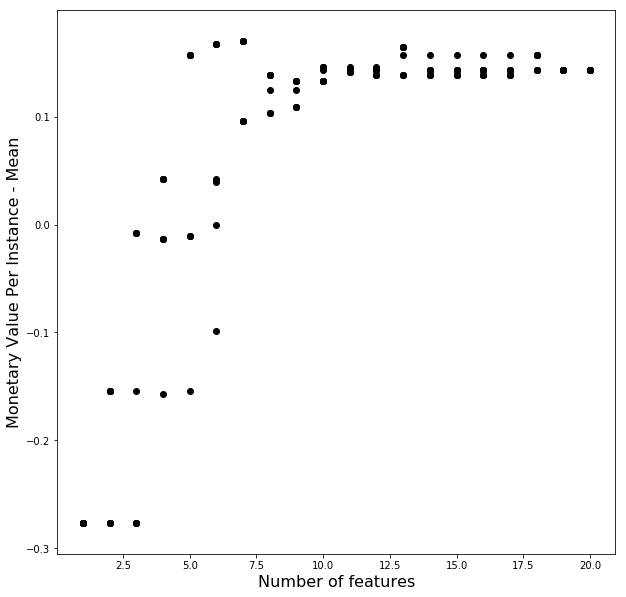

In [17]:
plt.rcParams['figure.figsize'] = (10,10)


sub_table = result_table[result_table["Model"] == "AdaBoostClassifier"]



plt.scatter(sub_table["Feature Count"],
            sub_table["Monetary Value Per Instance - Mean"],
             c = 'black'),


plt.xlabel('Number of features', fontsize=16)
plt.ylabel('Monetary Value Per Instance - Mean', fontsize=16)

#ggplot(aes(x='Feature Count', y='Monetary Value Per Instance - Mean', color='Data Preparation'), data=sub_table)  + geom_point()

Text(0, 0.5, 'Monetary Value Per Instance - Mean')

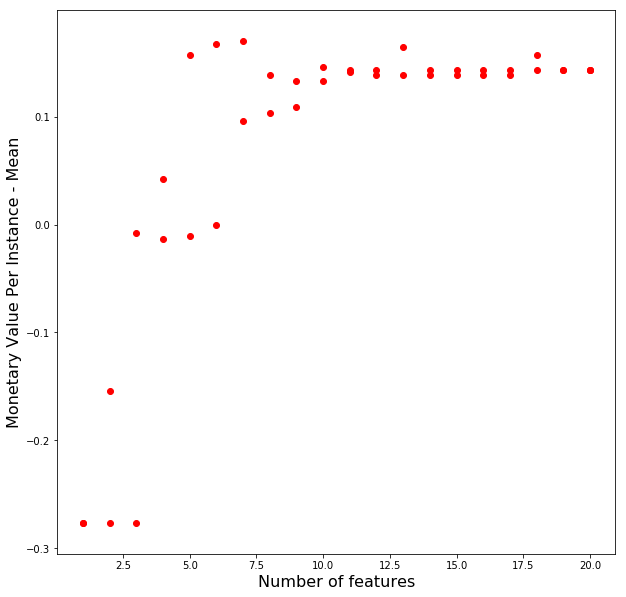

In [18]:
plt.scatter(sub_table["Feature Count"][sub_table['Data Preparation'] == 'No Scaling'],
            sub_table["Monetary Value Per Instance - Mean"][sub_table['Data Preparation'] == 'No Scaling'],
             c = 'red'),


plt.xlabel('Number of features', fontsize=16)
plt.ylabel('Monetary Value Per Instance - Mean', fontsize=16)

In [19]:
best_model = result_table_aggregated.loc[result_table_aggregated["Monetary Value Per Instance - Mean"].argmax()]["Raw Model"]
best_model_features = result_table_aggregated.loc[result_table_aggregated["Monetary Value Per Instance - Mean"].argmax()]["Features"]
best_parameters = result_table.loc[result_table["Monetary Value Per Instance - Mean"].argmax()]["Optimal Parameters"]

print(best_model)
print(best_model_features)
print(best_parameters)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=None)
['trustLevel' 'lineItemVoids' 'scansWithoutRegistration'
 'scannedLineItemsPerSecond' 'valuePerSecond' 'scannedLineItems'
 'scansWithoutRegistrationPerScannedLineItem']
{'algorithm': 'SAMME.R', 'base_estimator': DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_stat

Evaluate the result of all folds

In [20]:
cv_results = result_table.loc[result_table["Monetary Value Per Instance - Mean"].argmax()]["Cross Validation Results"]

cv_results

{'mean_fit_time': array([0.03849695, 0.11110268, 0.22808981, 0.28274341, 0.33241086,
        0.74460759, 0.97947946, 0.80993321, 1.07203188, 0.89779804,
        0.07061093, 0.0638293 , 0.09773848, 0.02902241, 0.13693364,
        0.00498657, 0.0051862 , 0.00518618, 0.00488682, 0.00488694,
        0.00339599, 0.0034905 , 0.00339091, 0.00319142, 0.0032912 ,
        0.03440771, 0.08387568, 0.17094269, 0.25421979, 0.32892034,
        0.03979342, 0.09454722, 0.1906898 , 0.29022348, 0.38427205,
        0.31645324, 0.69294581, 0.71897633, 0.90088971, 0.87128808,
        0.03380964, 0.01835096, 0.02742665, 0.03370993, 0.02832413,
        0.0050869 , 0.00538585, 0.0051862 , 0.00508654, 0.00508647,
        0.0038897 , 0.00369012, 0.00369005, 0.00378997, 0.00349069,
        0.04079063, 0.0977386 , 0.19098895, 0.28663325, 0.36951122]),
 'std_fit_time': array([7.08326834e-03, 2.71641025e-02, 2.52191378e-02, 4.12759904e-02,
        1.49403691e-02, 3.83794741e-01, 6.26496161e-01, 5.66936291e-01,
     

## Performance of the model on the entire train data set (when trained on the entire train data set)

In [23]:
from sklearn.metrics import confusion_matrix

def get_monetary_value(cm):
        tn, fp, fn, tp = cm.ravel()
        print("True negative: ", tn)
        print("False positive: ", fp)
        print("False negative: ", fn)
        print("True positive: ", tp)
        score = (-25)*fp + (-5)*fn + 5*tp
        print(str(score) + " for " + str(sum(sum(cm))) + " instances in the test set")
        print(str(score/sum(sum(cm))) + " per instance in the test set")
        return score
    
cm = confusion_matrix(train['fraud'] , best_model.predict(train[best_model_features]))

monetary_value = get_monetary_value(cm)

True negative:  1775
False positive:  0
False negative:  0
True positive:  104
520 for 1879 instances in the test set
0.2767429483767962 per instance in the test set


# Predictions on the entire test data set

In [24]:
test

,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition,scannedLineItems,pricePerScannedLineItem,scansWithoutRegistrationPerScannedLineItem,quantityModificationsPerScannedLineItem,lineItemVoidsPerSecond,scansWithoutRegistrationPerSecond,quantityModificationsPerSecond,secondsPerEuro,lineItemVoidsPerEuro,scansWithoutRegistrationPerEuro,quantityModificationsPerEuro
0,4,467,88.48,4,8,4,0.014989,0.189465,0.571429,7.0,12.640000,1.142857,0.571429,0.008565,0.017131,0.008565,5.278029,0.045208,0.090416,0.045208
1,3,1004,58.99,7,6,1,0.026892,0.058755,0.259259,27.0,2.184815,0.222222,0.037037,0.006972,0.005976,0.000996,17.019834,0.118664,0.101712,0.016952
2,1,162,14.00,4,5,4,0.006173,0.086420,4.000000,1.0,14.000000,5.000000,4.000000,0.024691,0.030864,0.024691,11.571429,0.285714,0.357143,0.285714
3,5,532,84.79,9,3,4,0.026316,0.159380,0.642857,14.0,6.056429,0.214286,0.285714,0.016917,0.005639,0.007519,6.274325,0.106145,0.035382,0.047175
4,5,890,42.16,4,0,0,0.021348,0.047371,0.210526,19.0,2.218947,0.000000,0.000000,0.004494,0.000000,0.000000,21.110057,0.094877,0.000000,0.000000
5,5,1072,12.67,3,4,1,0.019590,0.011819,0.142857,21.0,0.603333,0.190476,0.047619,0.002799,0.003731,0.000933,84.609313,0.236780,0.315706,0.078927
6,3,259,93.75,0,7,0,0.100386,0.361969,0.000000,26.0,3.605769,0.269231,0.000000,0.000000,0.027027,0.000000,2.762667,0.000000,0.074667,0.000000
7,2,1528,47.35,2,9,5,0.009817,0.030988,0.133333,15.0,3.156667,0.600000,0.333333,0.001309,0.005890,0.003272,32.270327,0.042239,0.190074,0.105597
8,6,816,80.89,9,4,0,0.017157,0.099130,0.642857,14.0,5.777857,0.285714,0.000000,0.011029,0.004902,0.000000,10.087774,0.111262,0.049450,0.000000
9,4,16,31.91,7,7,4,1.312500,1.994375,0.333333,21.0,1.519524,0.333333,0.190476,0.437500,0.437500,0.250000,0.501410,0.219367,0.219367,0.125353


In [25]:
predictions = best_model.predict(test[best_model_features])

In [26]:
len(predictions)

498121

In [27]:
predictions

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [28]:
predictions_df = pd.DataFrame(predictions)
predictions_df.columns = ['fraud']
predictions_df

,fraud
0,0
1,0
2,0
3,0
4,0
5,0
6,0
7,0
8,0
9,0


In [29]:
print(predictions_df.fraud.value_counts())
print(predictions_df.fraud.value_counts() / len(predictions_df))

0    475172
1     22949
Name: fraud, dtype: int64
0    0.953929
1    0.046071
Name: fraud, dtype: float64
